In [29]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = 'cpu'
from torchdiffeq import odeint

In [16]:
def FN_torch(t, V, a=0.2, b=0.2, c=3.0):
    return torch.hstack((c * (V[0] - V[0]**3/3 + V[1]), -1/c * (V[0] - a + b*V[1])))

def FN_torch_modified(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[0] - V[0]**3/3 + V[1])
    V2 = -1/c * (V[0] - a + b*V[1])
    dV = torch.hstack((V1, V2))
    terms = torch.tensor([V[0]**2, V[1]**2])
    dV += torch.matmul(eta, terms)
    return dV

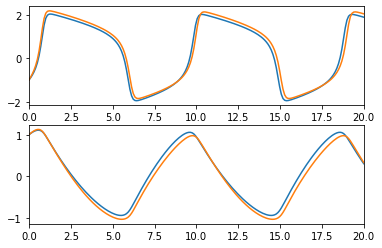

In [25]:
true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)

fn_true = lambda t, x : FN_torch_modified(t, x, true_eta)

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
soln = odeint(fn_true, x0, t_space)

soln_unpert = odeint(FN_torch, x0, t_space)

ax1 = plt.subplot(211)
ax1.set_xlim(0,ub)
plt.plot(t_space, soln_unpert[:,0])
plt.plot(t_space, soln[:,0])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t_space, soln_unpert[:,1])
plt.plot(t_space, soln[:,1])
plt.show()

In [40]:
class OptimizeFitzhugh(torch.nn.Module):
    
    def __init__(self, x0, t_space, n_terms, eta0):
        super(OptimizeFitzhugh, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms
        self.eta = eta0
        self.eta.requires_grad_()
        
    def rhs(self, x, t):
        return FN_torch_modified(t, x, self.eta)
    
    def forward(self, t, x):
        return self.rhs(x, t)

In [44]:
eta_method = 'random'
check_grads = False
max_it = 1000

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (2,2)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2,2)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

print(eta0)

with torch.no_grad():
    true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)
    true_FN = lambda t, x : FN_torch_modified(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)


optfitz = OptimizeFitzhugh(x0, t_space, 2, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-3)
loss = torch.nn.MSELoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optfitz, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    if check_grads:
        if it > 0:
            for i in range(optfitz.eta.shape[0]):
                for j in range(optfitz.eta.shape[1]):
                    print('Backprop Derivative for {},{} = {:.2f}'.format(i, j, optfitz.eta.grad[i,j]))
                    print('Checked Derivative for {},{} = {:.2f}'.format(i, j, grad_check[i,j]))
                    # print('Error Ratio = {:.2f}'.format(optfitz.eta.grad[i,j] / grad_check[i,j]))
                    print()
        print('\n')

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log.append(optfitz.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        if not (eta_method == 'actual' and it < 1):
            break

    loss_vec.append(loss_curr.detach().numpy())

    if check_grads:

        print('===Derivative Check===')

        grad_check = np.zeros((optfitz.eta.shape[0], optfitz.eta.shape[1]))
        for i in range(optfitz.eta.shape[0]):
            for j in range(optfitz.eta.shape[1]):
                eps = 10**(-3)
                eta_check_0 = optfitz.eta.detach().clone()
                eta_check_1 = optfitz.eta.detach().clone()

                eta_check_0[i,j] += eps
                eta_check_1[i,j] -= eps

                FN_check_0 = lambda t, S : FN_torch_modified(t, S, eta_check_0)
                x_pred_check_0 = odeint(FN_check_0, x0, t_space)
                FN_check_1 = lambda t, S : FN_torch_modified(t, S, eta_check_1)
                x_pred_check_1 = odeint(FN_check_1, x0, t_space)

                L0 = loss(x_pred_check_0, true_soln)
                L1 = loss(x_pred_check_1, true_soln)
                grad_check[i,j] = ((L0 - L1)/(2*eps)).item()

    optimizer.step()


tensor([[ 0.0020, -0.0012],
        [ 0.0001,  0.0020]])
eta_0 = 
[[ 0.002  -0.0012]
 [ 0.0001  0.002 ]]

Iterarion 1
eta = 
[[ 0.002  -0.0012]
 [ 0.0001  0.002 ]]
loss = 0.0287


Iterarion 2
eta = 
[[ 0.001  -0.0002]
 [ 0.0011  0.003 ]]
loss = 0.0221


Iterarion 3
eta = 
[[-9.7204e-06  7.9386e-04]
 [ 2.1252e-03  4.0076e-03]]
loss = 0.0169


Iterarion 4
eta = 
[[-0.0009  0.0018]
 [ 0.0031  0.005 ]]
loss = 0.0133


Iterarion 5
eta = 
[[-0.0015  0.0027]
 [ 0.004   0.0059]]
loss = 0.0113


Iterarion 6
eta = 
[[-0.0018  0.0037]
 [ 0.0049  0.0067]]
loss = 0.0107


Iterarion 7
eta = 
[[-0.0017  0.0046]
 [ 0.0056  0.0074]]
loss = 0.0112


Iterarion 8
eta = 
[[-0.0013  0.0054]
 [ 0.0061  0.008 ]]
loss = 0.0122


Iterarion 9
eta = 
[[-0.0007  0.0062]
 [ 0.0065  0.0083]]
loss = 0.0132


Iterarion 10
eta = 
[[-3.8503e-05  6.8951e-03]
 [ 6.7297e-03  8.4821e-03]]
loss = 0.0138


Iterarion 11
eta = 
[[0.0007 0.0075]
 [0.0068 0.0085]]
loss = 0.0138


Iterarion 12
eta = 
[[0.0016 0.0081]
 [0.0067 0.00

Iterarion 114
eta = 
[[0.0827 0.0756]
 [0.0062 0.0003]]
loss = 0.0047


Iterarion 115
eta = 
[[0.0834 0.0761]
 [0.0062 0.0002]]
loss = 0.0047


Iterarion 116
eta = 
[[0.0842 0.0767]
 [0.0062 0.0001]]
loss = 0.0047


Iterarion 117
eta = 
[[8.4889e-02 7.7186e-02]
 [6.1721e-03 3.7250e-05]]
loss = 0.0046


Iterarion 118
eta = 
[[ 8.5622e-02  7.7703e-02]
 [ 6.1768e-03 -3.4784e-05]]
loss = 0.0046


Iterarion 119
eta = 
[[ 0.0864  0.0782]
 [ 0.0062 -0.0001]]
loss = 0.0045


Iterarion 120
eta = 
[[ 0.0871  0.0787]
 [ 0.0062 -0.0002]]
loss = 0.0045


Iterarion 121
eta = 
[[ 0.0878  0.0792]
 [ 0.0062 -0.0002]]
loss = 0.0045


Iterarion 122
eta = 
[[ 0.0885  0.0797]
 [ 0.0062 -0.0003]]
loss = 0.0044


Iterarion 123
eta = 
[[ 0.0893  0.0802]
 [ 0.0062 -0.0004]]
loss = 0.0044


Iterarion 124
eta = 
[[ 0.09    0.0807]
 [ 0.0062 -0.0004]]
loss = 0.0043


Iterarion 125
eta = 
[[ 0.0907  0.0812]
 [ 0.0062 -0.0005]]
loss = 0.0043


Iterarion 126
eta = 
[[ 0.0914  0.0817]
 [ 0.0062 -0.0006]]
loss = 0.004

Iterarion 222
eta = 
[[ 0.1509  0.1007]
 [ 0.0065 -0.0035]]
loss = 0.0021


Iterarion 223
eta = 
[[ 0.1515  0.1006]
 [ 0.0065 -0.0035]]
loss = 0.0020


Iterarion 224
eta = 
[[ 0.152   0.1005]
 [ 0.0065 -0.0035]]
loss = 0.0020


Iterarion 225
eta = 
[[ 0.1525  0.1003]
 [ 0.0065 -0.0035]]
loss = 0.0020


Iterarion 226
eta = 
[[ 0.153   0.1002]
 [ 0.0065 -0.0034]]
loss = 0.0020


Iterarion 227
eta = 
[[ 0.1535  0.1001]
 [ 0.0065 -0.0034]]
loss = 0.0020


Iterarion 228
eta = 
[[ 0.1541  0.1   ]
 [ 0.0065 -0.0034]]
loss = 0.0020


Iterarion 229
eta = 
[[ 0.1546  0.0998]
 [ 0.0065 -0.0034]]
loss = 0.0020


Iterarion 230
eta = 
[[ 0.1551  0.0997]
 [ 0.0065 -0.0034]]
loss = 0.0019


Iterarion 231
eta = 
[[ 0.1556  0.0995]
 [ 0.0066 -0.0034]]
loss = 0.0019


Iterarion 232
eta = 
[[ 0.1561  0.0994]
 [ 0.0066 -0.0033]]
loss = 0.0019


Iterarion 233
eta = 
[[ 0.1566  0.0992]
 [ 0.0066 -0.0033]]
loss = 0.0019


Iterarion 234
eta = 
[[ 0.1571  0.099 ]
 [ 0.0066 -0.0033]]
loss = 0.0019


Iterarion 23

Iterarion 330
eta = 
[[0.1991 0.0716]
 [0.0064 0.002 ]]
loss = 0.0010


Iterarion 331
eta = 
[[0.1994 0.0713]
 [0.0064 0.0021]]
loss = 0.0010


Iterarion 332
eta = 
[[0.1998 0.0709]
 [0.0064 0.0022]]
loss = 0.0010


Iterarion 333
eta = 
[[0.2002 0.0706]
 [0.0064 0.0023]]
loss = 0.0010


Iterarion 334
eta = 
[[0.2006 0.0703]
 [0.0064 0.0024]]
loss = 0.0010


Iterarion 335
eta = 
[[0.2009 0.07  ]
 [0.0064 0.0025]]
loss = 0.0010


Iterarion 336
eta = 
[[0.2013 0.0697]
 [0.0064 0.0025]]
loss = 0.0010


Iterarion 337
eta = 
[[0.2017 0.0694]
 [0.0064 0.0026]]
loss = 0.0010


Iterarion 338
eta = 
[[0.2021 0.069 ]
 [0.0064 0.0027]]
loss = 0.0010


Iterarion 339
eta = 
[[0.2024 0.0687]
 [0.0064 0.0028]]
loss = 0.0010


Iterarion 340
eta = 
[[0.2028 0.0684]
 [0.0064 0.0029]]
loss = 0.0010


Iterarion 341
eta = 
[[0.2032 0.0681]
 [0.0064 0.003 ]]
loss = 0.0010


Iterarion 342
eta = 
[[0.2035 0.0678]
 [0.0064 0.003 ]]
loss = 0.0009


Iterarion 343
eta = 
[[0.2039 0.0675]
 [0.0064 0.0031]]
loss = 0

Iterarion 444
eta = 
[[0.2357 0.0411]
 [0.0055 0.0127]]
loss = 0.0005


Iterarion 445
eta = 
[[0.236  0.0409]
 [0.0055 0.0128]]
loss = 0.0005


Iterarion 446
eta = 
[[0.2363 0.0407]
 [0.0055 0.0129]]
loss = 0.0005


Iterarion 447
eta = 
[[0.2365 0.0405]
 [0.0055 0.013 ]]
loss = 0.0005


Iterarion 448
eta = 
[[0.2368 0.0403]
 [0.0054 0.0131]]
loss = 0.0005


Iterarion 449
eta = 
[[0.2371 0.0401]
 [0.0054 0.0132]]
loss = 0.0005


Iterarion 450
eta = 
[[0.2373 0.0399]
 [0.0054 0.0133]]
loss = 0.0004


Iterarion 451
eta = 
[[0.2376 0.0397]
 [0.0054 0.0134]]
loss = 0.0004


Iterarion 452
eta = 
[[0.2378 0.0395]
 [0.0054 0.0135]]
loss = 0.0004


Iterarion 453
eta = 
[[0.2381 0.0393]
 [0.0054 0.0136]]
loss = 0.0004


Iterarion 454
eta = 
[[0.2384 0.0391]
 [0.0054 0.0137]]
loss = 0.0004


Iterarion 455
eta = 
[[0.2386 0.0389]
 [0.0054 0.0138]]
loss = 0.0004


Iterarion 456
eta = 
[[0.2389 0.0387]
 [0.0053 0.014 ]]
loss = 0.0004


Iterarion 457
eta = 
[[0.2391 0.0385]
 [0.0053 0.0141]]
loss = 0

Iterarion 558
eta = 
[[0.261  0.023 ]
 [0.0041 0.0239]]
loss = 0.0002


Iterarion 559
eta = 
[[0.2611 0.0228]
 [0.0041 0.024 ]]
loss = 0.0002


Iterarion 560
eta = 
[[0.2613 0.0227]
 [0.004  0.0241]]
loss = 0.0002


Iterarion 561
eta = 
[[0.2615 0.0226]
 [0.004  0.0242]]
loss = 0.0002


Iterarion 562
eta = 
[[0.2617 0.0225]
 [0.004  0.0243]]
loss = 0.0002


Iterarion 563
eta = 
[[0.2618 0.0224]
 [0.004  0.0243]]
loss = 0.0002


Iterarion 564
eta = 
[[0.262  0.0223]
 [0.004  0.0244]]
loss = 0.0002


Iterarion 565
eta = 
[[0.2622 0.0221]
 [0.004  0.0245]]
loss = 0.0002


Iterarion 566
eta = 
[[0.2624 0.022 ]
 [0.004  0.0246]]
loss = 0.0002


Iterarion 567
eta = 
[[0.2625 0.0219]
 [0.004  0.0247]]
loss = 0.0002


Iterarion 568
eta = 
[[0.2627 0.0218]
 [0.0039 0.0248]]
loss = 0.0002


Iterarion 569
eta = 
[[0.2629 0.0217]
 [0.0039 0.0249]]
loss = 0.0002


Iterarion 570
eta = 
[[0.2631 0.0216]
 [0.0039 0.025 ]]
loss = 0.0002


Iterarion 571
eta = 
[[0.2632 0.0215]
 [0.0039 0.0251]]
loss = 0

Iterarion 672
eta = 
[[0.2773 0.0127]
 [0.0027 0.0332]]
loss = 0.0001


Iterarion 673
eta = 
[[0.2774 0.0126]
 [0.0027 0.0332]]
loss = 0.0001


Iterarion 674
eta = 
[[0.2775 0.0125]
 [0.0027 0.0333]]
loss = 0.0001


Iterarion 675
eta = 
[[0.2776 0.0125]
 [0.0027 0.0334]]
loss = 0.0001


Iterarion 676
eta = 
[[0.2778 0.0124]
 [0.0027 0.0334]]
loss = 0.0001


Iterarion 677
eta = 
[[0.2779 0.0123]
 [0.0027 0.0335]]
loss = 0.0001


Iterarion 678
eta = 
[[0.278  0.0123]
 [0.0027 0.0336]]
loss = 0.0001


Iterarion 679
eta = 
[[0.2781 0.0122]
 [0.0026 0.0337]]
loss = 0.0001


Iterarion 680
eta = 
[[0.2782 0.0121]
 [0.0026 0.0337]]
loss = 0.0001


Iterarion 681
eta = 
[[0.2783 0.0121]
 [0.0026 0.0338]]
loss = 0.0001


Iterarion 682
eta = 
[[0.2784 0.012 ]
 [0.0026 0.0339]]
loss = 0.0001


Iterarion 683
eta = 
[[0.2785 0.0119]
 [0.0026 0.0339]]
loss = 0.0001


Iterarion 684
eta = 
[[0.2786 0.0119]
 [0.0026 0.034 ]]
loss = 0.0001


Iterarion 685
eta = 
[[0.2787 0.0118]
 [0.0026 0.0341]]
loss = 0

Iterarion 786
eta = 
[[0.2874 0.0068]
 [0.0017 0.0399]]
loss = 0.0000


Iterarion 787
eta = 
[[0.2874 0.0068]
 [0.0017 0.04  ]]
loss = 0.0000


Iterarion 788
eta = 
[[0.2875 0.0068]
 [0.0017 0.04  ]]
loss = 0.0000


Iterarion 789
eta = 
[[0.2876 0.0067]
 [0.0016 0.0401]]
loss = 0.0000


Iterarion 790
eta = 
[[0.2876 0.0067]
 [0.0016 0.0401]]
loss = 0.0000


Iterarion 791
eta = 
[[0.2877 0.0067]
 [0.0016 0.0402]]
loss = 0.0000


Iterarion 792
eta = 
[[0.2878 0.0066]
 [0.0016 0.0402]]
loss = 0.0000


Iterarion 793
eta = 
[[0.2878 0.0066]
 [0.0016 0.0402]]
loss = 0.0000


Iterarion 794
eta = 
[[0.2879 0.0065]
 [0.0016 0.0403]]
loss = 0.0000


Iterarion 795
eta = 
[[0.288  0.0065]
 [0.0016 0.0403]]
loss = 0.0000


Iterarion 796
eta = 
[[0.288  0.0065]
 [0.0016 0.0404]]
loss = 0.0000


Iterarion 797
eta = 
[[0.2881 0.0064]
 [0.0016 0.0404]]
loss = 0.0000


Iterarion 798
eta = 
[[0.2882 0.0064]
 [0.0016 0.0405]]
loss = 0.0000


Iterarion 799
eta = 
[[0.2882 0.0064]
 [0.0016 0.0405]]
loss = 0

Iterarion 900
eta = 
[[0.2933 0.0036]
 [0.0009 0.0444]]
loss = 0.0000


Iterarion 901
eta = 
[[0.2933 0.0036]
 [0.0009 0.0444]]
loss = 0.0000


Iterarion 902
eta = 
[[0.2934 0.0035]
 [0.0009 0.0444]]
loss = 0.0000


Iterarion 903
eta = 
[[0.2934 0.0035]
 [0.0009 0.0444]]
loss = 0.0000


Iterarion 904
eta = 
[[0.2934 0.0035]
 [0.0009 0.0445]]
loss = 0.0000


Iterarion 905
eta = 
[[0.2935 0.0035]
 [0.0009 0.0445]]
loss = 0.0000


Iterarion 906
eta = 
[[0.2935 0.0035]
 [0.0009 0.0445]]
loss = 0.0000


Iterarion 907
eta = 
[[0.2935 0.0034]
 [0.0009 0.0446]]
loss = 0.0000


Iterarion 908
eta = 
[[0.2936 0.0034]
 [0.0009 0.0446]]
loss = 0.0000


Iterarion 909
eta = 
[[0.2936 0.0034]
 [0.0009 0.0446]]
loss = 0.0000


Iterarion 910
eta = 
[[0.2937 0.0034]
 [0.0009 0.0447]]
loss = 0.0000


Iterarion 911
eta = 
[[0.2937 0.0034]
 [0.0009 0.0447]]
loss = 0.0000


Iterarion 912
eta = 
[[0.2937 0.0033]
 [0.0009 0.0447]]
loss = 0.0000


Iterarion 913
eta = 
[[0.2938 0.0033]
 [0.0009 0.0447]]
loss = 0

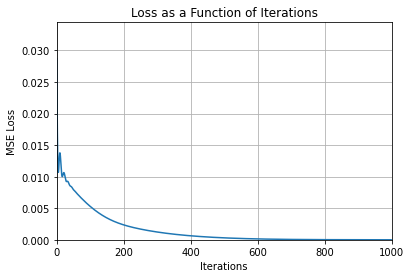

In [45]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_vec)), loss_vec)
ax.set_xlabel('Iterations')
ax.set_ylabel('MSE Loss')
ax.set_title('Loss as a Function of Iterations')
ax.set_xlim((0, max_it))
ax.set_ylim((0, max(loss_vec) * 1.2))
plt.grid()
plt.show()